# README.md

##Step1, read from spreadsheet 
#####get rid of lines with NaN in both start and end dates
#####detele the lines labeled as "deleted" in "comment"
#####keep only the ADT drugs 
#####get statistics: how many deleted, added, reviewed? how many pts? how many lines of adt drug usage? 

##Step2, for each pt, put all start dates into a list; and end dates into a list; compare within and across
##Step3, update the documentation; maybe could use SQL? 

###be careful of unreviewed cells; uncertainty 
###be careful of the cells that need discussion
###validate and crosscheck each step 
###fix date like may-2014

# Research question: What’s the initial ADT use time window for each pt? 

# Step1, read from spreadsheet, clean up, and get statistics

In [2]:
import numpy as np
import pandas as pd
import sys, getopt
import csv
from datetime import datetime
import itertools

from matplotlib import pyplot
from pylab import *
import matplotlib.pyplot as plt

%matplotlib inline  
import seaborn as sns

In [3]:
df1=pd.read_excel("../A3test.xls", header=0)

In [4]:
df1[:5]

,person_id,generic_drug_name,source,evidence,match_string,start_year,start_month,start_day,end_year,end_month,end_day,start_date,end_date,imputed_stage,comment,reason,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,12.0,Leuprolide,Medtable,NaN,NaN,2013.0,5.0,6.0,2013.0,5.0,6.0,2013-05-06 00:00:00,2013-05-06 00:00:00,NaN,reviewed,NaN,NaN,NaN,NaN,NaN
1,18.0,Goserelin,Medtable,NaN,NaN,2013.0,12.0,9.0,2014.0,3.0,13.0,2013-12-09 00:00:00,2014-03-13 00:00:00,NaN,reviewed,NaN,NaN,NaN,NaN,NaN
2,18.0,Degarelix,Medtable,NaN,NaN,2013.0,11.0,12.0,2013.0,11.0,12.0,2013-11-12 00:00:00,2013-11-12 00:00:00,NaN,reviewed,NaN,NaN,NaN,NaN,NaN
3,25.0,Leuprolide,Medtable,NaN,NaN,2013.0,11.0,12.0,2014.0,2.0,18.0,NaN,2014-02-18 00:00:00,NaN,reviewed,"The starting date is 8/2013, before the notes ...",NaN,NaN,NaN,NaN
4,25.0,Leuprolide,Notes,The patient was started on bicalutamide x 2 we...,NaN,2013.0,8.0,NaN,NaN,NaN,NaN,2013-08-01 00:00:00,NaN,NaN,added,NaN,NaN,NaN,NaN,NaN


In [5]:
index_list=df1.columns
index_list

Index(['person_id', 'generic_drug_name', 'source', 'evidence', 'match_string',
       'start_year', 'start_month', 'start_day', 'end_year', 'end_month',
       'end_day', 'start_date', 'end_date', 'imputed_stage', 'comment',
       'reason', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'],
      dtype='object')

In [6]:
#delete empty columns

print(df1.shape)
del_col=['evidence', 'match_string',
       'start_year', 'start_month', 'start_day', 'end_year', 'end_month',
       'end_day', 'imputed_stage','reason', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19']

for col in del_col:
    del df1[col]
print(df1.shape)

(656, 20)
(656, 6)


In [7]:
#change person_id to int
df1['person_id']=df1['person_id'].values.astype(int)

In [8]:
#df_test=df1[(df1["start_date"] == "may-2014")]
#df_test

In [9]:
#value=df1.at[483,"start_date"]
#print(value)
#df1.at[483,"start_date"]="2014-05-01 00:00:00"
#value=df1.at[483,"start_date"]
#print(value)

In [10]:
df1[:5]

,person_id,generic_drug_name,source,start_date,end_date,comment
0,12,Leuprolide,Medtable,2013-05-06 00:00:00,2013-05-06 00:00:00,reviewed
1,18,Goserelin,Medtable,2013-12-09 00:00:00,2014-03-13 00:00:00,reviewed
2,18,Degarelix,Medtable,2013-11-12 00:00:00,2013-11-12 00:00:00,reviewed
3,25,Leuprolide,Medtable,NaN,2014-02-18 00:00:00,reviewed
4,25,Leuprolide,Notes,2013-08-01 00:00:00,NaN,added


In [11]:
#remove empty cells 
df1['comment'].replace('', np.nan, inplace=True)
df1.dropna(subset=['comment'], inplace=True)
df1['start_date'].replace(u'\xa0', u'', inplace=True)
df1['end_date'].replace(u'\xa0', u'', inplace=True)
df1['start_date'].replace('', np.nan, inplace=True)
df1['end_date'].replace('', np.nan, inplace=True)

In [12]:
#print(df1.shape)
#df1.to_csv(r'check.csv', index = False)

In [13]:
#found out the number of pts
df_ptinfo=df1.groupby(["person_id"]).size().reset_index(name='counts')
print(df_ptinfo.shape)

(125, 2)


#  Get the numbers of deleted, reviewed and added lines from the chart review 

In [14]:
deleted_list=[]
reviewed_list=[]
added_list=[]

for ind in df1.index:
    if (df1['comment'][ind]=='deleted'): 
        deleted_list.append(ind)  
    if (df1['comment'][ind]=='reviewed'): 
        reviewed_list.append(ind)  
    if (df1['comment'][ind]=='added'): 
        added_list.append(ind)  

In [15]:
total_lines=len(deleted_list)+len(reviewed_list)+len(added_list)

print("Total number lines is: " +str(total_lines))
print("Number of deleted lines is: " +str(len(deleted_list)),  "; Percentage is "  +str(100*round(len(deleted_list)/total_lines,3)))
print("Number of reviewed lines is: " +str(len(reviewed_list)), "; Percentage is " +str(100*round(len(reviewed_list)/total_lines,1)))
print("Number of added lines is: " +str(len(added_list)),   "; Percentage is "     +str(100*round(len(added_list)/total_lines,3)))

Total number lines is: 396
Number of deleted lines is: 41 ; Percentage is 10.4
Number of reviewed lines is: 223 ; Percentage is 60.0
Number of added lines is: 132 ; Percentage is 33.300000000000004


In [16]:
###delete the lines that has deleted in the column "comment"
print(df1.shape)
for ind in deleted_list:
    df1.drop(index=ind,inplace=True)
print(df1.shape)

(414, 6)
(373, 6)


In [17]:
###Keep only the ones that are ADTs
ADT_lib=["Leuprolide", "Degarelix", "Goserelin", "Triptorelin", "Histrelin"]
not_adt_list=[]

#get the list
for ind in df1.index:
    if (df1['generic_drug_name'][ind] not in ADT_lib): 
        not_adt_list.append(ind) 
        
#delete the lines in the list
for ind in not_adt_list:
    df1.drop(index=ind,inplace=True)
    
print("Number of lines with a non ADT drug is ", len(not_adt_list))
print("shape of cleaned dataframe")
print(df1.shape)
df1.reset_index()

Number of lines with a non ADT drug is  122
shape of cleaned dataframe
(251, 6)


,index,person_id,generic_drug_name,source,start_date,end_date,comment
0,0,12,Leuprolide,Medtable,2013-05-06 00:00:00,2013-05-06 00:00:00,reviewed
1,1,18,Goserelin,Medtable,2013-12-09 00:00:00,2014-03-13 00:00:00,reviewed
2,2,18,Degarelix,Medtable,2013-11-12 00:00:00,2013-11-12 00:00:00,reviewed
3,3,25,Leuprolide,Medtable,NaN,2014-02-18 00:00:00,reviewed
4,4,25,Leuprolide,Notes,2013-08-01 00:00:00,NaN,added
...,...,...,...,...,...,...,...
246,643,36369,Leuprolide,Medtable,2016-01-07 00:00:00,2016-06-23 00:00:00,reviewed
247,646,36369,Degarelix,Notes,2019-04-15 00:00:00,NaN,added
248,647,36508,Leuprolide,Medtable,2015-10-07 00:00:00,2016-07-11 00:00:00,reviewed
249,653,36535,Degarelix,Notes,2017-08-09 00:00:00,NaN,reviewed


In [18]:
##check column start_date, end_date time format is correct
for i in df1.index:
    #print(pd.to_datetime(df1['start_date'][i], format='%d-%b-%Y'))
    #print(df1['start_date'][i])
    print(pd.to_datetime(df1['start_date'][i], format='%d-%b-%Y'))

2013-05-06 00:00:00
2013-12-09 00:00:00
2013-11-12 00:00:00
NaT
2013-08-01 00:00:00
2014-11-26 00:00:00
NaT
2015-11-18 00:00:00
2013-03-12 00:00:00
NaT
2013-02-15 00:00:00
2017-08-01 00:00:00
2017-09-13 00:00:00
2013-07-02 00:00:00
NaT
2015-06-18 00:00:00
2018-05-29 00:00:00
2017-07-12 00:00:00
2017-06-14 00:00:00
2014-05-21 00:00:00
NaT
2020-04-15 00:00:00
NaT
2018-07-03 00:00:00
NaT
NaT
2018-01-10 00:00:00
NaT
NaT
2017-01-11 00:00:00
2017-10-30 00:00:00
2018-04-25 00:00:00
2017-11-30 00:00:00
2015-06-18 00:00:00
2017-11-06 00:00:00
2018-09-12 00:00:00
NaT
2015-01-30 00:00:00
NaT
2015-12-03 00:00:00
NaT
2015-06-15 00:00:00
2015-09-03 00:00:00
2016-08-19 00:00:00
2017-10-30 00:00:00
2018-02-07 00:00:00
NaT
2016-03-15 00:00:00
NaT
2015-01-30 00:00:00
2015-03-03 00:00:00
2017-09-14 00:00:00
NaT
2016-08-31 00:00:00
2018-05-17 00:00:00
2018-04-17 00:00:00
2016-02-08 00:00:00
NaT
2019-09-10 00:00:00
NaT
2016-06-29 00:00:00
2016-08-17 00:00:00
NaT
2017-02-27 00:00:00
2018-06-13 00:00:00
2018

In [19]:
###crosscheck
#not_adt_list
###spotcheck 
test2 = df1[(df1["person_id"] == 36062)]
test2

,person_id,generic_drug_name,source,start_date,end_date,comment
638,36062,Leuprolide,Medtable,NaN,2016-06-07 00:00:00,reviewed
639,36062,Leuprolide,Notes,2014-04-24 00:00:00,NaN,reviewed
640,36062,Degarelix,Medtable,NaN,2020-05-07 00:00:00,reviewed
641,36062,Degarelix,Notes,2019-09-10 00:00:00,NaN,added


In [20]:
df1[240:250]

,person_id,generic_drug_name,source,start_date,end_date,comment
632,34807,Degarelix,Notes,2015-06-23 00:00:00,NaN,reviewed
635,35033,Degarelix,Medtable,2012-11-26 00:00:00,2012-11-26 00:00:00,reviewed
638,36062,Leuprolide,Medtable,NaN,2016-06-07 00:00:00,reviewed
639,36062,Leuprolide,Notes,2014-04-24 00:00:00,NaN,reviewed
640,36062,Degarelix,Medtable,NaN,2020-05-07 00:00:00,reviewed
641,36062,Degarelix,Notes,2019-09-10 00:00:00,NaN,added
643,36369,Leuprolide,Medtable,2016-01-07 00:00:00,2016-06-23 00:00:00,reviewed
646,36369,Degarelix,Notes,2019-04-15 00:00:00,NaN,added
647,36508,Leuprolide,Medtable,2015-10-07 00:00:00,2016-07-11 00:00:00,reviewed
653,36535,Degarelix,Notes,2017-08-09 00:00:00,NaN,reviewed


# Group by person_id

In [21]:
df2=df1.groupby(["person_id"]).size().reset_index(name='counts')

In [22]:
df2

,person_id,counts
0,12,1
1,18,2
2,25,2
3,26,2
4,38,1
...,...,...
116,35033,1
117,36062,4
118,36369,2
119,36508,1


In [23]:
df2.reset_index
df2.shape

(121, 2)

In [24]:
df2.index
df2['index1'] = df2.index

In [25]:
df2.columns

Index(['person_id', 'counts', 'index1'], dtype='object')

In [26]:
df2[['index1','counts']]

,index1,counts
0,0,1
1,1,2
2,2,2
3,3,2
4,4,1
...,...,...
116,116,1
117,117,4
118,118,2
119,119,1


Text(0.5, 1.0, 'Rows of info per pt')

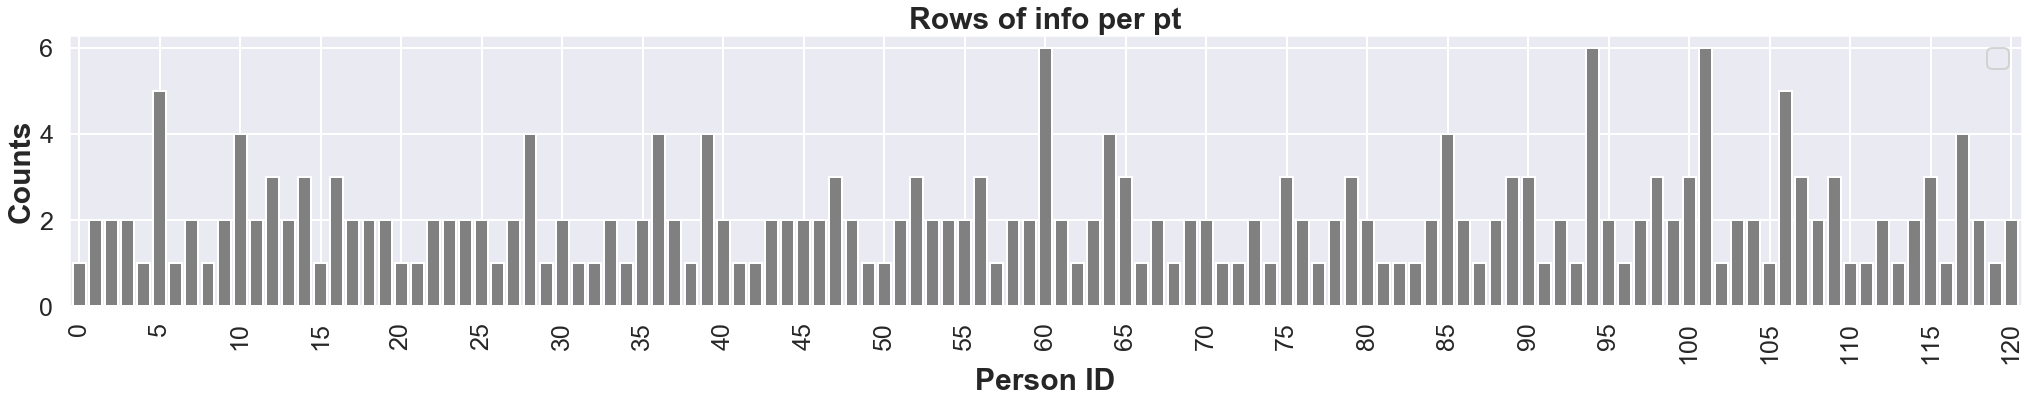

In [27]:
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.2, rc={"lines.linewidth": 2})

ax = df2.plot.bar(x='index1', y='counts', width=0.8, color='grey', rot=90, title ="LoT", figsize=(35, 5), legend=True, fontsize=12)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
ax.set_xticks(np.arange(0, len(df2.index)+1, 5))
ax.set_xticklabels(np.arange(0, len(df2.index)+1, 5))
plt.xlabel("Person ID", fontsize=30, fontweight="bold")
plt.ylabel("Counts", fontsize=30,fontweight="bold")
plt.legend("")
plt.title("Rows of info per pt",fontsize=30,fontweight="bold")
#ax = df2[['index1'],['counts']].plot(kind='bar', title ="LoT", figsize=(30, 10), legend=True, fontsize=12)

In [28]:
#get the list of pts with max numbers of entries recording ADT usage
df2["counts"].max()
df2[(df2["counts"] == 6)]

,person_id,counts,index1
60,19566,6,60
94,27966,6,94
101,30455,6,101


In [29]:
df2[(df2["counts"] == 6)]

,person_id,counts,index1
60,19566,6,60
94,27966,6,94
101,30455,6,101


In [30]:
##check
df1[(df1["person_id"] == 27966)]

,person_id,generic_drug_name,source,start_date,end_date,comment
483,27966,Leuprolide,Notes,2014-05-01 00:00:00,NaN,added
484,27966,Leuprolide,Notes,NaN,2015-03-15 00:00:00,added
485,27966,Leuprolide,Notes,2016-02-17 00:00:00,NaN,added
486,27966,Leuprolide,Notes,NaN,2016-06-16 00:00:00,added
487,27966,Leuprolide,Notes,2017-10-23 00:00:00,NaN,added
488,27966,Leuprolide,Medtable,NaN,2018-04-18 00:00:00,reviewed


In [31]:
y=27966

df_pt=df1[(df1["person_id"] == y)]
each_pt_drug_start = df_pt['start_date'].to_list()
each_pt_drug_end = df_pt['end_date'].to_list()

In [32]:
each_pt_drug_start

[datetime.datetime(2014, 5, 1, 0, 0),
 nan,
 datetime.datetime(2016, 2, 17, 0, 0),
 nan,
 datetime.datetime(2017, 10, 23, 0, 0),
 nan]

In [33]:
##get rid of nan
cleaned_a= [x for x in each_pt_drug_start if str(x) != 'NaN']
cleaned_aa= [x for x in cleaned_a if str(x) != 'nan']

cleaned_b= [x for x in each_pt_drug_end if str(x) != 'NaN']
cleaned_bb= [x for x in cleaned_b if str(x) != 'nan']

##get the date format right
#startdatebin=[datetime.fromisoformat(str(x)) for x in cleaned_aa]
#enddatebin=[datetime.fromisoformat(str(x)) for x in cleaned_bb]

#sort 
#start_sorted_bin=sorted(startdatebin)
#end_sorted_bin=sorted(enddatebin)
start_sorted_bin=sorted(cleaned_aa)
end_sorted_bin=sorted(cleaned_bb)

In [34]:
start_with_2round=[]
start_with_1round=[]

#for a,b in itertools.combinations(list, 2):
    #print((str(a),str(b)))
a=start_sorted_bin[0]

for b in start_sorted_bin:
#find all adt starting dates after 6months of inital starting    
    if float(abs(a-b).days)>182.5:
        start_with_2round.append(a)
        start_with_2round.append(b)
    else:
        start_with_1round.append(a) 
#cleanup 
start_with_2round=start_with_2round[:2]

#get rid of repeated capturing for one round
cleanlist = []
for i in start_with_1round:
    if i not in cleanlist:
        cleanlist.append(i)
start_with_1round=cleanlist

In [35]:
if len(start_with_2round)==2:
    print(start_with_2round)
if (len(start_with_2round)<2) and (len(start_with_1round)==1):
    print(start_with_1round)

[datetime.datetime(2014, 5, 1, 0, 0), datetime.datetime(2016, 2, 17, 0, 0)]


In [36]:
enddateall=[]
enddate=[]

for i in end_sorted_bin:
#at least two rounds of ADTs
    if len(start_with_2round)==2:
        if(i>sorted(start_with_2round)[0]) and (i<sorted(start_with_2round)[1]):
            startdate=sorted(start_with_2round)[0]
            enddateall.append(i)
        #pick the one that is most close to the 2nd adt starting date
        enddate=enddateall[-1]
        
#only one round           
    if (len(start_with_2round)<2) and (len(start_with_1round)==1):
        if(i>sorted(start_with_1round)[0]):
            startdate=start_with_1round[0]
            enddateall.append(i)  
        enddate=enddateall[0]

print(y, startdate, enddate, enddate-startdate)

27966 2014-05-01 00:00:00 2015-03-15 00:00:00 318 days, 0:00:00


# iterate, plot windows, save csv

In [37]:
#get the list of pt ids
list_pts=df2["person_id"].to_list()
list_pts

[12,
 18,
 25,
 26,
 38,
 110,
 119,
 323,
 387,
 870,
 2526,
 2660,
 3079,
 3951,
 3995,
 5452,
 6077,
 6162,
 6445,
 6955,
 7236,
 8024,
 8544,
 9048,
 9233,
 9888,
 10578,
 10945,
 11482,
 11595,
 11613,
 11649,
 11651,
 11859,
 11861,
 11933,
 12187,
 12208,
 12275,
 12374,
 12426,
 12427,
 12720,
 13274,
 13609,
 13728,
 14846,
 15082,
 15202,
 15456,
 16116,
 16273,
 16477,
 17206,
 17341,
 17419,
 17559,
 17638,
 18362,
 19342,
 19566,
 20270,
 20929,
 20930,
 21003,
 21389,
 21480,
 21543,
 21613,
 21655,
 21938,
 22100,
 22103,
 22129,
 22567,
 22676,
 22860,
 23559,
 23945,
 24143,
 24226,
 24383,
 24562,
 24582,
 24782,
 24830,
 25017,
 25882,
 26082,
 26152,
 26854,
 27180,
 27458,
 27543,
 27966,
 28445,
 28474,
 29307,
 29359,
 30078,
 30211,
 30455,
 30492,
 30689,
 30997,
 31074,
 31131,
 31430,
 31676,
 32740,
 33531,
 33555,
 33586,
 33871,
 34207,
 34807,
 35033,
 36062,
 36369,
 36508,
 36535]

In [38]:
#for i in list_pts:
for y in [27966,30455,19566,36062]:    
    #subset the dataframe to each pt
    #get start dates and end dates to lists
    df_pt=df1[(df1["person_id"] == y)]
    
    each_pt_drug_start = df_pt['start_date'].to_list()
    each_pt_drug_end = df_pt['end_date'].to_list()

    ##get rid of nan
    cleaned_a= [x for x in each_pt_drug_start if str(x) != 'NaN']
    cleaned_aa= [x for x in cleaned_a if str(x) != 'nan']

    cleaned_b= [x for x in each_pt_drug_end if str(x) != 'NaN']
    cleaned_bb= [x for x in cleaned_b if str(x) != 'nan']

    ##get the date format right
    #startdatebin=[datetime.fromisoformat(str(x)) for x in cleaned_aa]
    #enddatebin=[datetime.fromisoformat(str(x)) for x in cleaned_bb]

    #sort 
    start_sorted_bin=sorted(cleaned_aa)
    end_sorted_bin=sorted(cleaned_bb)
    
    start_with_2round=[]
    start_with_1round=[]
    a=start_sorted_bin[0]

    for b in start_sorted_bin:
    #find all adt starting dates after 6months of inital starting    
        if float(abs(a-b).days)>182.5:
            start_with_2round.append(a)
            start_with_2round.append(b)
        else:
            start_with_1round.append(a) 
    #cleanup 
    start_with_2round=start_with_2round[:2]

    #get rid of repeated capturing for one round
    cleanlist = []
    for i in start_with_1round:
        if i not in cleanlist:
            cleanlist.append(i)
    start_with_1round=cleanlist
    
    enddateall=[]
    enddate=[]

    for i in end_sorted_bin:
    #at least two rounds of ADTs
        if len(start_with_2round)==2:
            if(i>sorted(start_with_2round)[0]) and (i<sorted(start_with_2round)[1]):
                startdate=sorted(start_with_2round)[0]
                enddateall.append(i)
            #pick the one that is most close to the 2nd adt starting date
            enddate=enddateall[-1]
        
    #only one round           
        if (len(start_with_2round)<2) and (len(start_with_1round)==1):
            if(i>sorted(start_with_1round)[0]):
                startdate=start_with_1round[0]
                enddateall.append(i)  
            enddate=enddateall[0]

    print(y, startdate, enddate, enddate-startdate)

27966 2014-05-01 00:00:00 2015-03-15 00:00:00 318 days, 0:00:00
30455 2015-01-23 00:00:00 2015-07-01 00:00:00 159 days, 0:00:00
19566 2017-01-30 00:00:00 2017-10-01 00:00:00 244 days, 0:00:00
36062 2014-04-24 00:00:00 2016-06-07 00:00:00 775 days, 0:00:00


# plot start date; plot inital adt window

In [39]:
df_pt=df1[(df1["person_id"]==18)]
df_pt

,person_id,generic_drug_name,source,start_date,end_date,comment
1,18,Goserelin,Medtable,2013-12-09 00:00:00,2014-03-13 00:00:00,reviewed
2,18,Degarelix,Medtable,2013-11-12 00:00:00,2013-11-12 00:00:00,reviewed


In [40]:
result_list=[]
for y in list_pts:    

    #subset the dataframe to each pt
    #get start dates and end dates to lists
    df_pt=df1[(df1["person_id"] == y)]
    
    each_pt_drug_start = df_pt['start_date'].to_list()
    each_pt_drug_end = df_pt['end_date'].to_list()

    ##get rid of nan
    cleaned_a= [x for x in each_pt_drug_start if str(x) != 'NaN']
    cleaned_aa= [x for x in cleaned_a if str(x) != 'nan']

    cleaned_b= [x for x in each_pt_drug_end if str(x) != 'NaN']
    cleaned_bb= [x for x in cleaned_b if str(x) != 'nan']
    
    ##get the date format right
    #startdatebin=[datetime.fromisoformat(str(x)) for x in cleaned_aa]
    #enddatebin=[datetime.fromisoformat(str(x)) for x in cleaned_bb]

    #sort 
    start_sorted_bin=sorted(cleaned_aa)
    end_sorted_bin=sorted(cleaned_bb)
    
    start_with_2round=[]
    start_with_1round=[]
    if(len(start_sorted_bin)>0):
        a=start_sorted_bin[0]
    else:
        startdate='NaN'

    for b in start_sorted_bin:
    #find all adt starting dates after 6months of inital starting    
        if float(abs(a-b).days)>182.5:
            start_with_2round.append(a)
            start_with_2round.append(b)
        else:
            start_with_1round.append(a) 
    #cleanup 
    start_with_2round=start_with_2round[:2]

    #get rid of repeated capturing for one round
    cleanlist = []
    for i in start_with_1round:
        if i not in cleanlist:
            cleanlist.append(i)
    start_with_1round=cleanlist
    
    enddateall=[]

    for i in end_sorted_bin:
    #at least two rounds of ADTs
        if len(start_with_2round)==2:
            if(i>=sorted(start_with_2round)[0]) and (i<=sorted(start_with_2round)[1]):
                startdate=sorted(start_with_2round)[0]
                enddateall.append(i)
            #pick the one that is most close to the 2nd adt starting date
            if len(enddateall) == 0:
                enddate='NaN' 
            else:
                enddate=enddateall[-1]
            
            #when there are end dates that are later than the end of the intial adt usage
            if(i>sorted(start_with_2round)[0]) and (i>sorted(start_with_2round)[1]) and (len(enddateall) == 0):
                startdate=sorted(start_with_2round)[0]
                enddate='NaN'
                #leave it as empty
        
    #only one round           
        if (len(start_with_2round)<2) and (len(start_with_1round)==1):
            if(i>=sorted(start_with_1round)[0]):
                startdate=start_with_1round[0]
                enddateall.append(i)
            if len(enddateall) == 0:
                enddate='NaN' 
            else:
                enddate=enddateall[-1]
    print(y, startdate, enddate)
    result_per_pt=[y,startdate, enddate]
    result_list.append(result_per_pt)

12 2013-05-06 00:00:00 2013-05-06 00:00:00
18 2013-11-12 00:00:00 2014-03-13 00:00:00
25 2013-08-01 00:00:00 2014-02-18 00:00:00
26 2014-11-26 00:00:00 2016-09-14 00:00:00
38 2015-11-18 00:00:00 2016-07-18 00:00:00
110 2013-02-15 00:00:00 2014-11-25 00:00:00
119 2013-07-02 00:00:00 2013-10-02 00:00:00
323 2015-06-18 00:00:00 2016-09-07 00:00:00
387 2018-05-29 00:00:00 2018-08-21 00:00:00
870 2017-06-14 00:00:00 2017-10-13 00:00:00
2526 2014-05-21 00:00:00 2016-10-12 00:00:00
2660 2018-07-03 00:00:00 2018-10-09 00:00:00
3079 2018-01-10 00:00:00 2020-08-17 00:00:00
3951 2017-01-11 00:00:00 2018-10-10 00:00:00
3995 2017-10-30 00:00:00 2018-08-30 00:00:00
5452 2015-06-18 00:00:00 2015-06-18 00:00:00
6077 2017-11-06 00:00:00 NaN
6162 2015-01-30 00:00:00 2015-07-20 00:00:00
6445 2015-12-03 00:00:00 2016-08-03 00:00:00
6955 2015-06-15 00:00:00 2016-01-25 00:00:00
7236 2016-08-19 00:00:00 2017-01-04 00:00:00
8024 2017-10-30 00:00:00 2018-01-29 00:00:00
8544 2018-02-07 00:00:00 2018-11-21 00:00

In [41]:
df_results=pd.DataFrame(result_list)
df_results.columns=(['person_id', 'inital_ADT_start_date', 'inital_ADT_end_date'])

In [42]:
df_results

,person_id,inital_ADT_start_date,inital_ADT_end_date
0,12,2013-05-06,2013-05-06
1,18,2013-11-12,2014-03-13
2,25,2013-08-01,2014-02-18
3,26,2014-11-26,2016-09-14
4,38,2015-11-18,2016-07-18
...,...,...,...
116,35033,2012-11-26,2012-11-26
117,36062,2014-04-24,2016-06-07
118,36369,2016-01-07,2016-06-23
119,36508,2015-10-07,2016-07-11


In [43]:
#create a column for the time window 
df_results['Inital_ADT_timewindow'] = df_results['inital_ADT_end_date'] - df_results['inital_ADT_start_date']

In [44]:
#create a column for the time window 
df_results['Inital_ADT_timewindow'] = df_results['inital_ADT_end_date'] - df_results['inital_ADT_start_date']
#create a column for the inital adt use window as days
df_results['Inital_ADT_time_window_days']=df_results['Inital_ADT_timewindow'].dt.days

In [45]:
df_results
df_results['index1'] = df_results.index
df_results

,person_id,inital_ADT_start_date,inital_ADT_end_date,Inital_ADT_timewindow,Inital_ADT_time_window_days,index1
0,12,2013-05-06,2013-05-06,0 days,0.0,0
1,18,2013-11-12,2014-03-13,121 days,121.0,1
2,25,2013-08-01,2014-02-18,201 days,201.0,2
3,26,2014-11-26,2016-09-14,658 days,658.0,3
4,38,2015-11-18,2016-07-18,243 days,243.0,4
...,...,...,...,...,...,...
116,35033,2012-11-26,2012-11-26,0 days,0.0,116
117,36062,2014-04-24,2016-06-07,775 days,775.0,117
118,36369,2016-01-07,2016-06-23,168 days,168.0,118
119,36508,2015-10-07,2016-07-11,278 days,278.0,119


Text(0.5, 1.0, 'Inital ADT Use Duration')

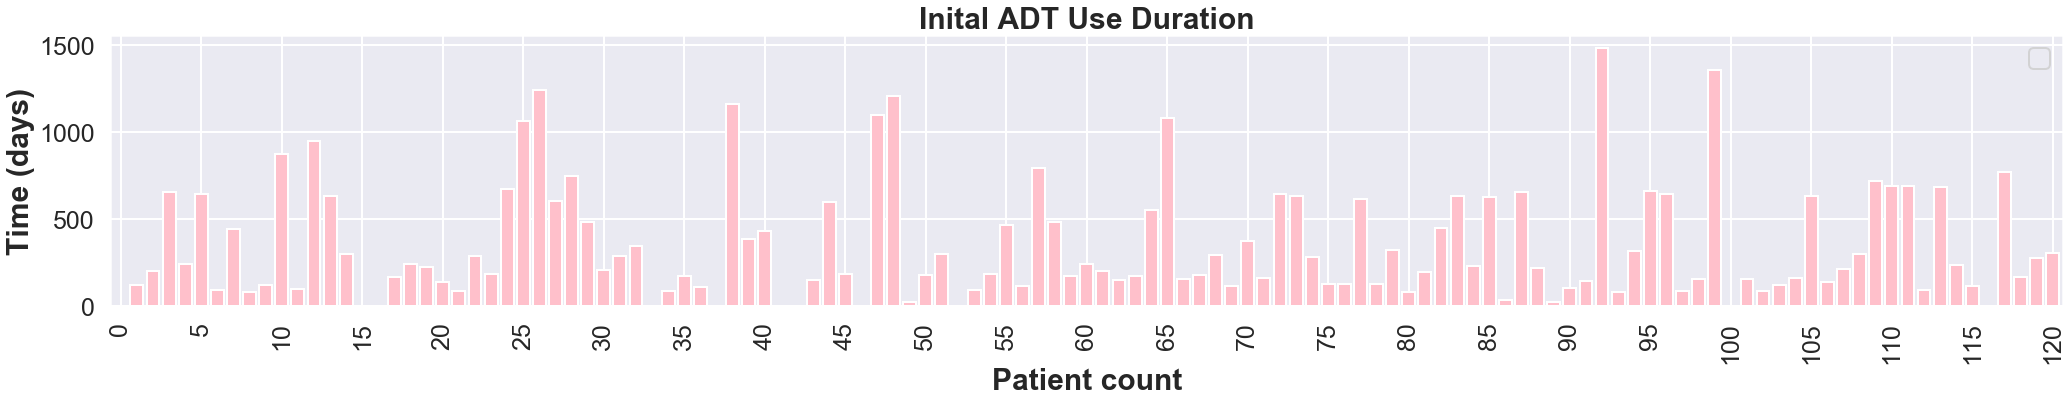

In [46]:
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.2, rc={"lines.linewidth": 2})

ax = df_results.plot.bar(x='index1', y='Inital_ADT_time_window_days', width=0.8, color='pink', rot=90, figsize=(35, 5), legend=True, fontsize=12)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)

ax.set_xticks(np.arange(0, len(df_results.index)+1, 5))
ax.set_xticklabels(np.arange(0, len(df_results.index)+1, 5))

plt.xlabel("Patient count", fontsize=30, fontweight="bold")
plt.ylabel("Time (days)", fontsize=30,fontweight="bold")
plt.legend("")
plt.title("Inital ADT Use Duration",fontsize=30,fontweight="bold" )
#ax = df2[['index1'],['counts']].plot(kind='bar', title ="LoT", figsize=(30, 10), legend=True, fontsize=12)

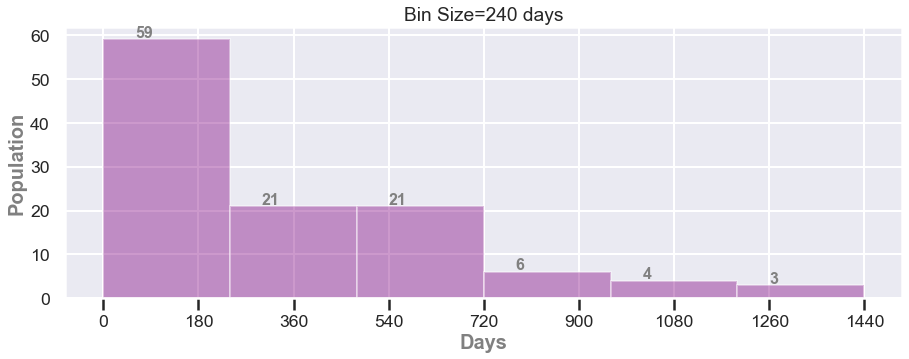

In [47]:
## sns.set_style("darkgrid")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 2})
binsize=240

bins=np.arange(0, 1500, binsize)
fig, ax = plt.subplots(figsize = (15,5))

#n=df_results['Inital_ADT_time_window_days'].plot(kind = "hist", bins=bins, color="purple", alpha=0.5)
(n, bins, patches) = plt.hist(df_results['Inital_ADT_time_window_days'], bins=bins,color="purple", alpha=0.4)

#decorate
plt.title("Bin Size="+ str(binsize) +" days")
plt.xlabel("Days", fontsize=20, fontweight="bold",color="gray")
plt.ylabel("Population", fontsize=20,fontweight="bold", color="gray")

ax.set_xticks(np.arange(0, 1501, 180))
ax.set_xticklabels(np.arange(0, 1501, 180))

# plot the label/text to each bin
for i in range(0, len(n)):
    x_pos = (bins[i + 1] - bins[i])/4 + bins[i]
    y_pos = n[i] + 0.5
    label = str(int(n[i])) # relative frequency of each bin
    ax.text(x_pos, y_pos, label,fontsize=16,fontweight="bold",color="gray" )
    ax.xaxis.tick_bottom()

In [48]:
#fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

In [49]:
bins=np.arange(0, 1500, 90)
bins

array([   0,   90,  180,  270,  360,  450,  540,  630,  720,  810,  900,
        990, 1080, 1170, 1260, 1350, 1440])

In [50]:
n

array([59., 21., 21.,  6.,  4.,  3.])

In [51]:
df_results.to_csv("Inital_ADT_use_time_window.csv", encoding='utf-8', index=False)

In [52]:
result_list=[]

#for y in [19566,31131,36062]:        
for y in [12]:
    #subset the dataframe to each pt
    #get start dates and end dates to lists
    df_pt=df1[(df1["person_id"] == y)]
    
    each_pt_drug_start = df_pt['start_date'].to_list()
    each_pt_drug_end = df_pt['end_date'].to_list()

    ##get rid of nan
    cleaned_a= [x for x in each_pt_drug_start if str(x) != 'NaN']
    cleaned_aa= [x for x in cleaned_a if str(x) != 'nan']

    cleaned_b= [x for x in each_pt_drug_end if str(x) != 'NaN']
    cleaned_bb= [x for x in cleaned_b if str(x) != 'nan']
    
    ##get the date format right
    #startdatebin=[datetime.fromisoformat(str(x)) for x in cleaned_aa]
    #enddatebin=[datetime.fromisoformat(str(x)) for x in cleaned_bb]

    #sort 
    start_sorted_bin=sorted(cleaned_aa)
    end_sorted_bin=sorted(cleaned_bb)
    
    start_with_2round=[]
    start_with_1round=[]
    if(len(start_sorted_bin)>0):
        a=start_sorted_bin[0]
    else:
        startdate='NaN'

    for b in start_sorted_bin:
    #find all adt starting dates after 6months of inital starting    
        if float(abs(a-b).days)>182.5:
            start_with_2round.append(a)
            start_with_2round.append(b)
        else:
            start_with_1round.append(a) 
    #cleanup 
    start_with_2round=start_with_2round[:2]

    #get rid of repeated capturing for one round
    cleanlist = []
    for i in start_with_1round:
        if i not in cleanlist:
            cleanlist.append(i)
    start_with_1round=cleanlist
    
    enddateall=[]

###if both time entries are empty or end is empty and start only has one
    if len(end_sorted_bin)==0:
        enddate='NaN'
        if(len(start_sorted_bin)==0):
            startdate='NaN' 
        if(len(start_sorted_bin)>0):    
            startdate=start_with_1round[0]
            
    if len(end_sorted_bin)>0:
        for i in end_sorted_bin:
        #at least two rounds of ADTs
            if len(start_with_2round)==2:
                if(i>=sorted(start_with_2round)[0]) and (i<=sorted(start_with_2round)[1]):
                    startdate=sorted(start_with_2round)[0]
                    enddateall.append(i)
                    #print(enddateall)
                    #pick the one that is most close to the 2nd adt starting date
                    if len(enddateall) == 0:
                        enddate='NaN' 
                    else:
                        enddate=enddateall[-1]
            
                if(i>sorted(start_with_2round)[0]) and (i>sorted(start_with_2round)[1]) and (len(enddateall) == 0):
                    startdate=sorted(start_with_2round)[0]
                    enddate='NaN'
                    #leave it as empty
        
        #only one round           
            if (len(start_with_2round)<2) and (len(start_with_1round)==1):
                if(i>=sorted(start_with_1round)[0]):
                    startdate=start_with_1round[0]
                    enddateall.append(i)
                    if len(enddateall) == 0:
                        enddate='NaN' 
                    else:
                        enddate=enddateall[-1]
                           
    print(y, startdate, enddate)
    result_per_pt=[y,startdate, enddate]
    result_list.append(result_per_pt)

12 2013-05-06 00:00:00 2013-05-06 00:00:00
